# Base algorithm for features' importance classification

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import pickle
from lime.lime_tabular import LimeTabularExplainer

labels = ["NoEvents", "Attack", "Natural"]

X = pd.read_csv("Data/data%d.csv"%1) #read file

X = X.replace(np.inf, np.finfo(np.float32).max) #replacing 'inf' with its equivalent in float32 datatype

#preparing the label converter
le = preprocessing.LabelEncoder()
le.fit(labels)

#assigning the training data and the labels into variables
y = le.transform(X['marker'])
X = X.drop(columns='marker')

features = list(X.columns)

clf = DecisionTreeClassifier()
X=X.values

clf.fit(X,y)

explainer = LimeTabularExplainer(X, training_labels = y, feature_names = features, class_names = labels)


Xall = []
for i in range(2,16):
    Xall.append(pd.read_csv("Data/data%d.csv"%i))

Xall = pd.concat(Xall)
Xall = Xall.replace(np.inf, np.finfo(np.float32).max) #replacing 'inf' with its equivalent in float32 datatype

#assigning the training data and the labels into variables
yall = le.transform(Xall['marker'])
Xall = Xall.drop(columns='marker')

boole = (yall != clf.predict(Xall))

faulty = boole & (yall == 0)
X_test = Xall[faulty]
y_test = yall[faulty]
lst = []
for idx in range(0, 100):
    exp = explainer.explain_instance(X_test[idx], clf.predict_proba, num_features=128, labels=[0, 1, 2])
    lst.append(exp.as_list(label=0))
lst = np.array(lst)
clst = np.concatenate(lst, axis=0)
dtfr = pd.DataFrame(clst, columns=['feature', 'importance'])
dtfr["importance"] = pd.to_numeric(dtfr["importance"])
dtfr = dtfr.groupby(['feature']).mean()
res = dtfr.sort_values(by="importance")
  


In [73]:
res 

,importance
feature,
R3:F > 60.00,-0.016330
R2-PA7:VH <= -101.20,-0.010771
R4-PA2:VH <= -95.89,-0.008911
R2-PA6:IH > 81.51,-0.007957
R1-PA1:VH > 71.28,-0.007917
...,...
R3-PM6:I <= 318.25,0.005361
R1-PA:Z > 12.43,0.005471
R4-PA5:IH > 115.38,0.005963


# Choosen features values modification

In [2]:
from sklearn.metrics import classification_report

print(classification_report(yall, clf.predict(Xall), labels=[0,1,2], target_names=labels))

precision    recall  f1-score   support

    NoEvents       0.72      0.76      0.74     51797
      Attack       0.27      0.26      0.26     17382
     Natural       0.19      0.08      0.12      4232

    accuracy                           0.60     73411
   macro avg       0.39      0.37      0.37     73411
weighted avg       0.58      0.60      0.59     73411



In [27]:
Xmod = Xall.copy()

def modify(feat, val):
    Xmod[feat] =Xmod[feat].apply(lambda x: x + val)


modify("R4-PA5:IH", -115.38)
modify("R3-PM2:V", 128525.29)
modify("R2-PM1:V", 2000)
modify("R1-PA12:IH", 32.04)
modify("R3-PM5:I", 330.7)

modify("R3:S", 0)
modify("R2-PA7:VH", 101.20)
modify("R2-PM1:V", -1300872.03)
modify("R3-PA7:VH", 101.22)
modify("R3-PA2:VH", 93.75)



modify("R2:F", -60)
modify("R3:F", -60)
modify("R2-PA5:IH",- 63.30)
modify("R2-PM7:V", -130857.40)
modify("R1-PA1:VH", -72.28)


In [28]:
print(classification_report(yall, clf.predict(Xmod), labels=[0,1,2], target_names=labels))

precision    recall  f1-score   support

    NoEvents       0.71      0.83      0.77     51797
      Attack       0.26      0.17      0.21     17382
     Natural       0.10      0.03      0.05      4232

    accuracy                           0.63     73411
   macro avg       0.36      0.34      0.34     73411
weighted avg       0.57      0.63      0.59     73411



In [76]:
yall[15]

2

In [78]:
exp = explainer.explain_instance(Xall.iloc[15], clf.predict_proba, num_features=128, labels=[0, 1, 2])
lst = exp.as_list()
lst = np.array(lst)
dtfr = pd.DataFrame(lst, columns=['feature', 'importance'])
dtfr["importance"] = pd.to_numeric(dtfr["importance"])
dtfr = dtfr.groupby(['feature']).mean()
res = dtfr.sort_values(by="importance")

In [79]:
res

,importance
feature,
R2-PA8:VH <= 0.00,-0.010952
relay4_log <= 0.00,-0.010254
R3-PA8:VH <= 0.00,-0.007786
R1-PA8:VH <= 0.00,-0.007464
R3-PM6:I <= 318.25,-0.007126
...,...
R2-PM1:V > 130872.03,0.004933
R2-PM2:V > 130805.80,0.005550
R4:S <= 0.00,0.005780


In [85]:
Xall.iloc[15]["R1-PA9:VH"] 

0.0

In [114]:
Xall.at[15, "R1-PA9:VH"] = 0
Xall.at[15, "R4-PA2:VH"] = -95,89


In [4]:
Xall = []
for i in range(2,16):
    Xall.append(pd.read_csv("Data/data%d.csv"%i))

Xall = pd.concat(Xall)
Xall = Xall.replace(np.inf, np.finfo(np.float32).max) #replacing 'inf' with its equivalent in float32 datatype

#assigning the training data and the labels into variables
yall = le.transform(Xall['marker'])
Xall = Xall.drop(columns='marker')

Xtrue = Xall.iloc[clf.predict(Xall) == yall]
ytrue = yall[clf.predict(Xall) == yall]
Xfalse = Xall.iloc[clf.predict(Xall) != yall]
yfalse = yall[clf.predict(Xall) != yall]
Xnoevents = Xfalse.iloc[clf.predict(Xfalse) == 0]
ynoevents = yfalse[clf.predict(Xfalse) == 0]
Xattack = Xfalse.iloc[clf.predict(Xfalse) == 1]
yattack = yfalse[clf.predict(Xfalse) == 1]
Xnatural = Xfalse.iloc[clf.predict(Xfalse) == 2]
ynatural = yfalse[clf.predict(Xfalse) == 2]

# Distance calculation 

In [58]:
def distance(X1, X2):
    return np.sqrt((((X1 - X2).apply(np.square)).sum()))


In [59]:
distance(Xtrue.iloc[0], Xtrue.iloc[1])

447.906171867984

In [62]:
ytrue[[3,4]]

array([2, 2])

In [63]:
x0 = Xtrue[ytrue == 0]
x1 = Xtrue[ytrue == 1]
x2 = Xtrue[ytrue == 2]

In [126]:
[distance(x1.iloc[k], x1.iloc[k+1]) for k in np.random.randint(0, x1.shape[0]-1, 1000)] #show all distances

6.0438976413908,
 402.7825831427793,
 4.812319096523503e+38,
 673.9226303532612,
 44.00142369193508,
 128.51931663062024,
 4954.299556461246,
 7405.197685655902,
 3.4028234663852886e+38,
 232.29595024651297,
 4.812319096523503e+38,
 3.4028234663852886e+38,
 4.812319096523503e+38,
 194.07628482132918,
 290.00683923094294,
 3.4028234663852886e+38,
 4.812319096523503e+38,
 133.46238033634967,
 4.812319096523503e+38,
 44.84422462200333,
 4.812319096523503e+38,
 91.0181133761872,
 26.565491569230673,
 6088.312047062188,
 219.53417932545267,
 2121.9753076373768,
 71.27273125102218,
 3.4028234663852886e+38,
 564.3688423532692,
 4.812319096523503e+38,
 36.25859821550484,
 4.812319096523503e+38,
 10042.186979663908,
 2303.1189417558244,
 422.8453321289722,
 4.812319096523503e+38,
 985.8143516451597,
 4.812319096523503e+38,
 119.47382223332183,
 63.861266690764154,
 6.72410616215784,
 36.90360039613256,
 45.91685483731988,
 1194.9578376628672,
 4.812319096523503e+38,
 321.2139217367676,
 846.935

In [67]:
np.median([distance(x1.iloc[k], x1.iloc[k+1]) for k in np.random.randint(0, x1.shape[0]-1, 1000)])

417.16356260789263

In [68]:
np.median([distance(x2.iloc[k], x2.iloc[k+1]) for k in np.random.randint(0, x2.shape[0]-1, 1000)])

162.45824349026418

In [69]:
np.median([distance(Xnoevents.iloc[k], Xnoevents.iloc[k+1]) for k in np.random.randint(0, Xnoevents.shape[0]-1, 1000)])

175.70517680429862

# Process mining

In [100]:
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

res.reset_index(level=0, inplace=True)
res.rename(columns={'feature':'case:concept:name', 'importance':'time:importance'}, inplace=True)
res.drop_duplicates(inplace = True)

temp = []
for case in res["case:feature"]:
    for feat in features:
        if feat in case:
            temp.append(feat)
            break

res["concept:name"] = temp

res = dataframe_utils.convert_timestamp_columns_in_df(res)
res = res.sort_values('time:importance')

log = log_converter.apply(res)

In [110]:
res

,index,case:concept:name,time:importance,concept:name
0,0,R4-PA1:VH <= -97.13,-0.143536,R4-PA1:VH
1,1,R3:F > 60.00,-0.088735,R3:F
2,2,R1-PM10:I <= 318.61,-0.081665,R1-PM10:I
3,3,R2-PA5:IH > 63.30,-0.061288,R2-PA5:IH
4,4,R1-PA:Z <= 8.19,-0.059460,R1-PA:Z
...,...,...,...,...
365,365,9.79 < R1-PA:Z <= 12.43,0.048480,R1-PA:Z
366,366,R1-PM12:I > 7.51,0.048508,R1-PM12:I
367,367,R4-PA1:VH > 71.50,0.050741,R4-PA1:VH
368,368,R2-PA4:IH <= -64.39,0.052901,R2-PA4:IH


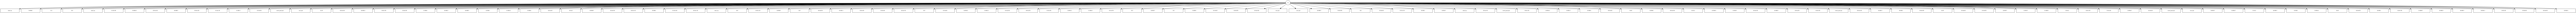

In [104]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.process_tree import visualizer as pt_visualizer

# create the process tree
tree = inductive_miner.apply_tree(log)

# viz
gviz = pt_visualizer.apply(tree)
pt_visualizer.view(gviz)
pt_visualizer.save(gviz, "file.png")

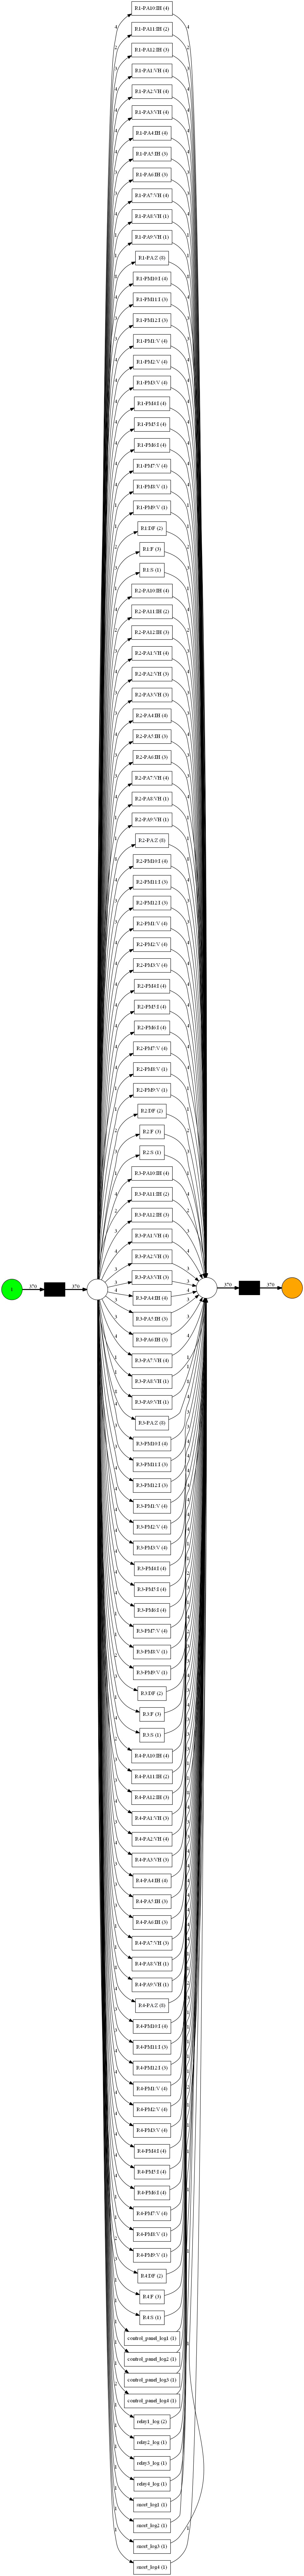

In [102]:
from pm4py.visualization.petrinet import visualizer as pn_visualizer
from pm4py.objects.conversion.process_tree import converter as pt_converter

# convert the process tree to a petri net
net, initial_marking, final_marking = pt_converter.apply(tree)

# alternatively, use the inductive_miner to create a petri net from scratch
# net, initial_marking, final_marking = inductive_miner.apply(log)

# viz
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                           parameters=parameters, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)
pn_visualizer.view(gviz)

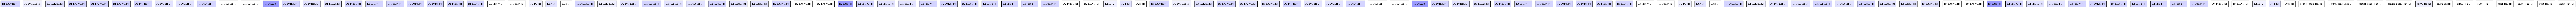

In [106]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization

# creatig the graph from log
dfg = dfg_discovery.apply(log)

# viz
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)